In [4]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

%matplotlib inline

In [2]:
mRNA_file = "./data/mRNA/out.tsv"
clinical_file = "./data/clinical/out.tsv"

In [3]:
t0 = time.time()
mRNA_df = pd.read_csv(mRNA_file, delimiter="\t")
print(time.time()-t0)

70.9515631198883


### Drop Genes with Null expression values
Since genes with nulls in them have completely different histogram compared to genes without nulls in them, 
the genes with nulls are dropped

In [9]:
# Compare the histogram of genes with Null Values and the genes without

In [10]:
transposed_df = mRNA_df.set_index("gene_id").transpose()
genes_with_nulls = transposed_df.columns[transposed_df.isnull().values.any(axis=0)]
genes_without_nulls = [i for i in transposed_df.columns if i not in genes_with_nulls]

In [14]:
print("number of genes with nulls:", len(genes_with_nulls))
print("number of genes with null values:", len(genes_without_nulls))
print("total number of genes:", transposed_df.shape[1])

number of genes with nulls: 4196
number of genes with null values: 16335
total number of genes: 20531


In [40]:
hist_with_nulls = transposed_df[genes_with_nulls].as_matrix().flatten()
hist_with_nulls = hist_with_nulls[~np.isnan(hist_with_nulls)] # remove nan values so that a histogram can be plotted
hist_without_nulls = transposed_df[genes_without_nulls].as_matrix().flatten()
hist_all = transposed_df.as_matrix().flatten()
hist_all = hist_all[~np.isnan(hist_all)]

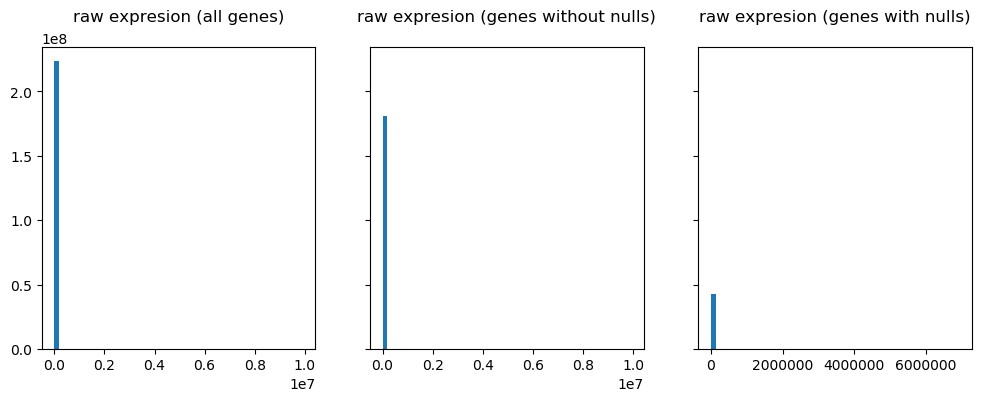

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=3, dpi=100, figsize=(12,4), sharey=True)
axes[2].hist(hist_with_nulls, bins=50)
axes[2].set_title("raw expresion (genes with nulls)\n")
axes[1].hist(hist_without_nulls, bins=50)
axes[1].set_title("raw expresion (genes without nulls)\n")
axes[0].hist(hist_all, bins=50)
axes[0].set_title("raw expresion (all genes)\n")
plt.show()

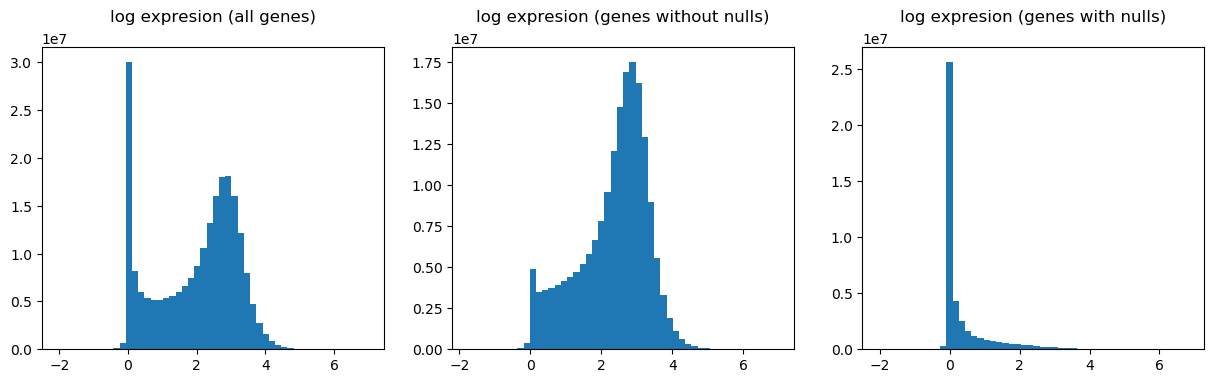

In [117]:
fig, axes = plt.subplots(nrows=1, ncols=3, dpi=100, figsize=(15,4))
log_hist_with_nulls = np.log10(hist_with_nulls+1)
log_hist_without_nulls = np.log10(hist_without_nulls+1)
log_hist_all = np.log10(hist_all+1)
axes[2].hist(log_hist_with_nulls, bins=50)
axes[2].set_title("log expresion (genes with nulls)\n")
axes[1].hist(log_hist_without_nulls, bins=50)
axes[1].set_title("log expresion (genes without nulls)\n")
axes[0].hist(log_hist_all, bins=50)
axes[0].set_title("log expresion (all genes)\n")
plt.show()

### Log transformation

In [119]:
log_df = np.log10(transposed_df.dropna(axis=1) + 1)
log_df.index.name="sample_id"

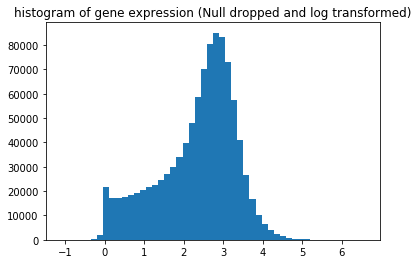

In [122]:
sample = np.random.choice(log_df.as_matrix().flatten(), size=1000000)
plt.hist(sample, bins=50)
plt.title("histogram of gene expression (Null dropped and log transformed)")
plt.show()

In [124]:
log_df.to_csv("./data/mRNA_lognorm.csv")
log_df.to_hdf("./data/mRNA_lognorm.hdf")

### Rescale data with MinMax, Standard and Robust Scaler

In [7]:
def histogram_plotter(X, title, bins=50, xlim=None):
    sample = np.random.choice(X.as_matrix().flatten(), size=1000000)
    plt.hist(sample, bins=bins)
    if xlim:
        plt.xlim(xlim)
    plt.title(title)
    plt.show()

In [4]:
df = pd.read_hdf("./data/mRNA_lognorm.hdf", index_col="sample_id")

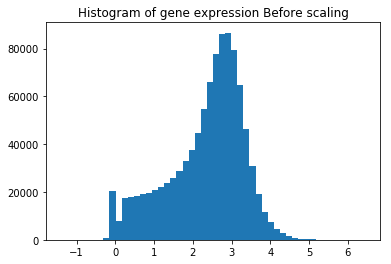

MinMax


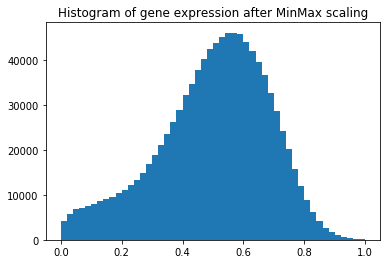

Standard


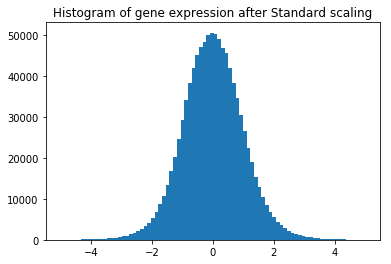

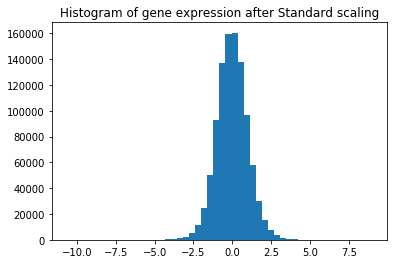

Robust


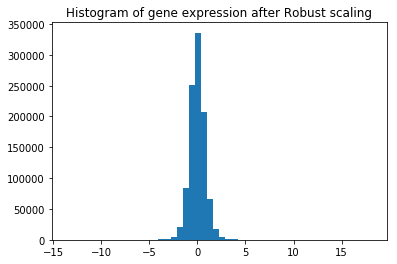

In [10]:
scaler_dict = {"MinMax": MinMaxScaler(), 
               "Standard": StandardScaler(), 
               "Robust": RobustScaler()}

histogram_plotter(df, "Histogram of gene expression Before scaling")

for scaler_name, scaler in scaler_dict.items():
    print(scaler_name)
    X_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
    if scaler_name == "Standard":
        histogram_plotter(X_scaled, "Histogram of gene expression after {0} scaling".format(scaler_name),
                          bins=200, xlim=(-5.5,5.5))
    histogram_plotter(X_scaled, "Histogram of gene expression after {0} scaling".format(scaler_name))
    X_scaled.to_hdf("./data/mRNA_lognorm_{0}Scaled.hdf".format(scaler_name), scaler_name)

### Extract labels
1. tissue of origin, 
2. gender 
3. tumor v.s. normal
4. age at diagnosis

#### 1 & 2 tissue and gender

In [1]:
def get_label(barcode, dic):
    patient_id = barcode[:12]
    if patient_id in dic:
        return dic[patient_id]
    else:
        return None

In [4]:
clinical_df = pd.read_csv(clinical_file, delimiter="\t", 
                          encoding="ISO-8859-1", low_memory=False)
df = pd.read_csv("./data/mRNA_lognorm_MinMaxScaled.csv")

In [7]:
tissue_dict = dict(zip(clinical_df.bcr_patient_barcode, clinical_df.acronym))
gender_dict = dict(zip(clinical_df.bcr_patient_barcode, clinical_df.gender))

In [8]:
label_df = pd.DataFrame(index=df.sample_id)
label_df["label_tissue"] = list(df.sample_id.apply(lambda x: get_label(x, tissue_dict)))
label_df["label_gender"] = list(df.sample_id.apply(lambda x: get_label(x, gender_dict)))

#### tumor v.s. normal label
Only save primary solid tumor, solid tumor normal, metastatic, and recurrent solid tumor.   
Here is the link to look up sample code: https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/sample-type-codes

In [9]:
CODE_DICT = {"01": "primary solid tumor",  
             "11": "solid tissue normal",
             "06": "metastatic",
             "03": "Primary Blood Derived Cancer - Peripheral Blood",
             "02": "Recurrent Solid Tumor",
             "05": None, #"05": "Additional - New Primary"
             "07": None, #"07": "Additional Metastatic"
            }

def extract_sample_type(barcode):
    tumor_type = barcode.split("-")[3][:2]
    if CODE_DICT[tumor_type] is None:
        return None
    else:
        return CODE_DICT[tumor_type]

In [10]:
label_df["label_tumor"] = list(df.sample_id.apply(extract_sample_type))

In [11]:
label_df.dropna().label_tumor.value_counts() 
# primary blood cancer tumor type is dropped because they don't have gender or tissue labels

primary solid tumor      9684
solid tissue normal       720
metastatic                395
Recurrent Solid Tumor      46
Name: label_tumor, dtype: int64

#### Age at diagnosis

In [49]:
def get_age(barcode):
    patient_id = barcode[:12]
    if patient_id in age_dict:
        return age_dict[patient_id]
    else:
        return np.nan

In [50]:
label_df = pd.read_csv("./data/labels.csv")
clinical_df = pd.read_csv("./data/clinical/out.tsv", 
                          delimiter="\t", encoding="ISO-8859-1", low_memory=False)
age_dict = clinical_df.set_index("bcr_patient_barcode")["age_at_initial_pathologic_diagnosis"].to_dict()
label_df["label_age"] = label_df.sample_id.apply(get_age)
label_df["label_age"] = label_df.label_age.replace("[Not Available]", np.nan)

### Look at Label distributions

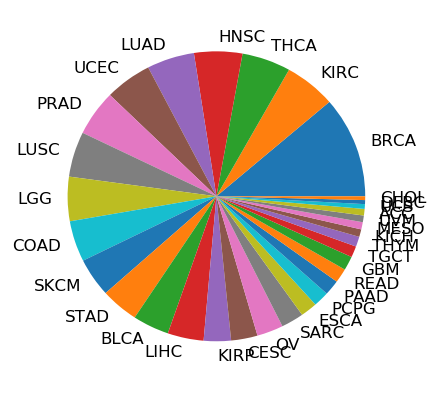

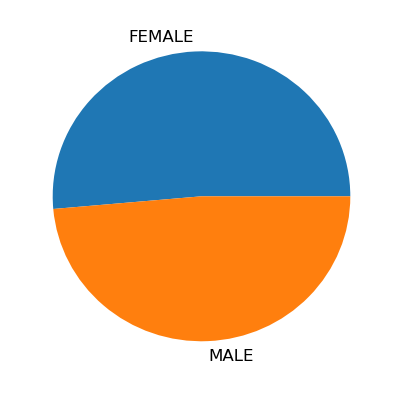

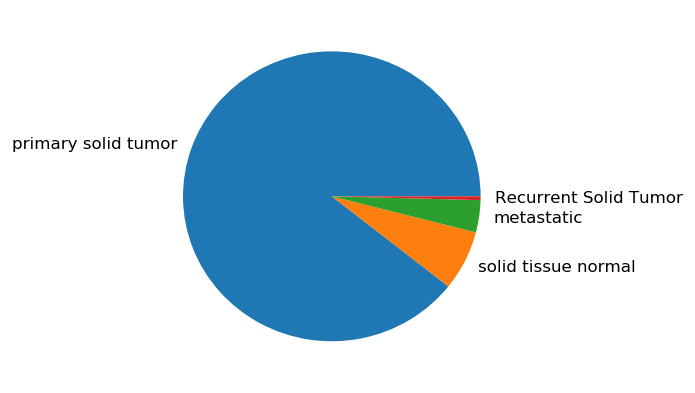

In [53]:
for each_label in ["tissue", "gender", "tumor"]:
    label_name = "label_" + each_label
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4), dpi=120)
    (label_df.dropna()[label_name].value_counts(dropna=False)/\
         float(label_df.dropna().shape[0])*100).plot.pie(ax=ax)
#     plt.title(each_label)
#     plt.xticks(rotation=45)
    plt.ylabel("")
    plt.show()

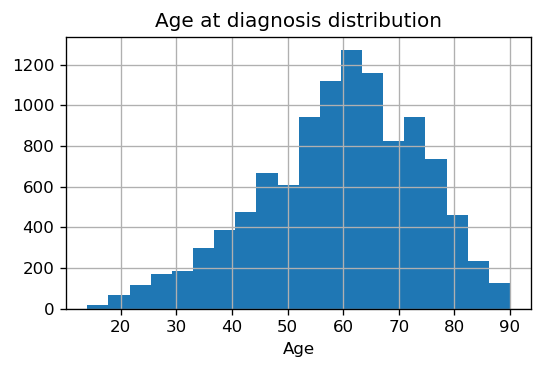

In [87]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,3), dpi=120)
label_df.label_age.dropna().astype("float").hist(bins=20)
plt.title("Age at diagnosis distribution")
plt.xlabel("Age")
plt.show()

In [90]:
label_df.to_csv("./data/labels.csv")